# Dataset

In [1]:
!pip install -q wandb tqdm matplotlib diffusers fastcore fastprogress torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.8/895.8 kB 57.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.2/213.2 kB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00


In [2]:
from pathlib import Path

def ls(path: Path):
    "Return files on Path, sorted"
    return sorted(list(path.iterdir()))

In [3]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
from pathlib import Path

import numpy as np
import torch
import torchvision.transforms as T
import wandb
from tqdm import tqdm as progress_bar
import cv2


PROJECT_NAME = "cloud_diffusion"
DATASET_ARTIFACT = 'ai-industry/cloud_diffusion/SEVIR:v0'

class DummyNextFrameDataset:
    "Dataset that returns random images"
    def __init__(self, num_frames=4, img_size=64, N=1000):
        self.img_size = img_size
        self.num_frames = num_frames
        self.N = N

    def __getitem__(self, idx):
        return torch.randn(self.num_frames, self.img_size, self.img_size)

    def __len__(self):
        return self.N


class CloudDataset:
    """Dataset for cloud images
    It loads numpy files from wandb artifact and stacks them into a single array
    It also applies some transformations to the images
    """
    def __init__(self,
                 files, # list of numpy files to load (they come from the artifact)
                 num_frames=4, # how many consecutive frames to stack
                 scale=True, # if we images to interval [-0.5, 0.5]
                 img_size=64, # resize dim, original images are big (446, 780)
                 valid=False, # if True, transforms are deterministic
                ):
        #self.means=[]
        #self.stds=[]
        #tfms = [T.Normalize(self.means, self.stds)]
        tfms = [T.RandomCrop(img_size)] if not valid else [T.CenterCrop(img_size)]
        self.tfms = T.Compose(tfms)
        self.load_data(files, num_frames, scale)


    def _scale(self, arr):
        "Scales values of array in [0,1]"
        m, M = arr.min(), arr.max()
        return (arr - m) / (M - m)

    def _calculate_mean_std(self, arr):
        "Calculate mean and std for normalization"
        mean, std = arr.mean(), arr.std()
        self.means.append(mean)
        self.stds.append(std)

    def _resize(self, arr, img_size):
        num_events, num_frames = arr.shape[0], arr.shape[3]
        resized_array = np.empty((num_events, img_size, img_size, num_frames))
        for event in range(num_events):
            resized_array[event] = cv2.resize(arr[event], (img_size, img_size))
        return resized_array.transpose((0, 3, 1, 2))

    def load_channel(self, file, scale=True):
        one_channel = np.load(file)
        one_channel = one_channel.astype('float32')
        if scale:
            one_channel = 0.5 - self._scale(one_channel)
            # self._calculate_mean_std(one_channel)
        return one_channel

    def create_windows(self, data, num_frames):
        windows = []
        for event in data:
            wds = np.lib.stride_tricks.sliding_window_view(
                        event,
                        num_frames,
                        axis=0)[::num_frames].transpose(0,4,1,2,3) # (windows, frames, channels, height, width)
            windows.append(wds)
        windows = np.array(windows)
        shape = windows.shape
        windows = windows.reshape(shape[0] * shape[1], shape[2], shape[3], shape[4], shape[5])
        windows = windows.astype('float32')
        return windows # (batch, channels, frames, height, width)

    def load_data(self, files, num_frames, scale, img_size=64):
        "Loads all data into a single array self.data"
        channels = []
        # Load all channels
        for file in progress_bar(files, leave=False):
            one_channel = self.load_channel(file, scale)
            resized_array = self._resize(one_channel, img_size)
            channels.append(resized_array)
            del one_channel
        all_channels = np.stack(channels, axis=2)
        self.data = self.create_windows(all_channels, num_frames)

    def shuffle(self):
        """Shuffles the dataset, useful for getting
        interesting samples on the validation dataset"""
        idxs = torch.randperm(len(self.data))
        self.data = self.data[idxs]
        return self

    @staticmethod
    def _scale(arr):
        "Scales values of array in [0,1]"
        m, M = arr.min(), arr.max()
        return (arr - m) / (M - m)

    def __getitem__(self, idx):
        return self.tfms(torch.from_numpy(self.data[idx]))

    def __len__(self): return len(self.data)

    def save(self, fname="cloud_frames.npy"):
        np.save(fname, self.data)

def download_dataset(at_name, project_name):
    "Downloads dataset from wandb artifact"
    def _get_dataset(run):
        artifact = run.use_artifact(at_name, type='dataset')
        return artifact.download()

    if wandb.run is not None:
        run = wandb.run
        artifact_dir = _get_dataset(run)
    else:
        run = wandb.init(project=project_name, job_type="download_dataset")
        artifact_dir = _get_dataset(run)
        run.finish()

    files = ls(Path(artifact_dir))
    return files

In [5]:
files = download_dataset(DATASET_ARTIFACT, project_name=PROJECT_NAME)
train_ds = CloudDataset(files)
print(f"Let's grab 5 samples: {train_ds[0:5].shape}")

wandb: Currently logged in as: maidacundo. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact SEVIR:v0, 2756.25MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:1:2.8


Let's grab 5 samples: torch.Size([5, 4, 3, 64, 64])


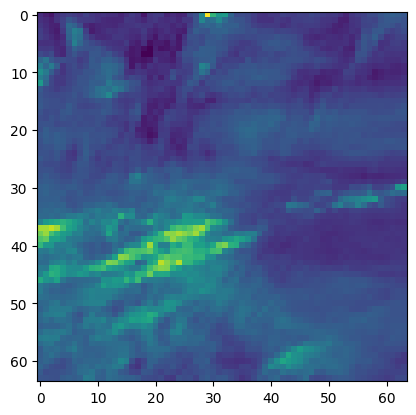

In [6]:
# Show the first sample image of the training dataset
import matplotlib.pyplot as plt

plt.imshow(train_ds[0][0][0])
plt.show()

# Model

In [8]:
from pathlib import Path

import wandb
import fastcore.all as fc

import torch
from torch import nn
from diffusers import UNet2DModel



def init_unet(model):
    "From Jeremy's bag of tricks on fastai V2 2023"
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): nn.init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

class WandbModel:
    "A model that can be saved to wandb"
    @classmethod
    def from_checkpoint(cls, model_params, checkpoint_file):
        "Load a UNet2D model from a checkpoint file"
        model = cls(**model_params)
        print(f"Loading model from: {checkpoint_file}")
        model.load_state_dict(torch.load(checkpoint_file))
        return model

    @classmethod
    def from_artifact(cls, model_params, artifact_name):
        "Load a UNet2D model from a wandb.Artifact, need to be run in a wandb run"
        artifact = wandb.use_artifact(artifact_name, type='model')
        artifact_dir = Path(artifact.download())
        chpt_file = list(artifact_dir.glob("*.pth"))[0]
        return cls.from_checkpoint(model_params, chpt_file)

def get_unet_params(model_name="unet_small", num_frames=4*3): # TODO parametrize the num frames and num channels
    "Return the parameters for the diffusers UNet2d model"
    if model_name == "unet_small":
        return dict(
            block_out_channels=(16, 32, 64, 128), # number of channels for each block
            norm_num_groups=8, # number of groups for the normalization layer
            in_channels=num_frames, # number of input channels
            out_channels=1, # number of output channels
            )
    elif model_name == "unet_big":
        return dict(
            block_out_channels=(32, 64, 128, 256), # number of channels for each block
            norm_num_groups=8, # number of groups for the normalization layer
            in_channels=num_frames, # number of input channels
            out_channels=1, # number of output channels
            )
    else:
        raise(f"Model name not found: {model_name}, choose between 'unet_small' or 'unet_big'")

class UNet2D(UNet2DModel, WandbModel):
    def __init__(self, *x, **kwargs):
        super().__init__(*x, **kwargs)
        init_unet(self)

    def forward(self, *x, **kwargs):
        return super().forward(*x, **kwargs).sample ## Diffusers's UNet2DOutput class

In [67]:
from pathlib import Path

import torch
import wandb
import numpy as np

## For Training

def to_wandb_image(img):
    "Convert a tensor to a wandb.Image"
    return wandb.Image(torch.cat(img.split(1), dim=-1).cpu().numpy())

def log_images(xt, samples):
    "Log sampled images to wandb"
    device = samples.device
    frames = torch.cat([xt, samples], dim=1)
    wandb.log({"sampled_images": [to_wandb_image(img) for img in frames]})

def save_model(model, model_name):
    "Save the model to wandb"
    model_name = f"{wandb.run.id}_{model_name}"
    models_folder = Path("models")
    if not models_folder.exists():
        models_folder.mkdir()
    torch.save(model.state_dict(), models_folder/f"{model_name}.pth")
    at = wandb.Artifact(model_name, type="model")
    at.add_file(f"models/{model_name}.pth")
    wandb.log_artifact(at)


## For Inference
def htile(img):
    "Horizontally tile a batch of images."
    return torch.cat(img.split(1), dim=-1)

def vtile(img):
    "Vertically tile a batch of images."
    return torch.cat(img.split(1), dim=-2)

def vhtile(*imgs):
    "Vertically and horizontally tile a batch of images."
    return vtile(torch.cat([htile(img) for img in imgs], dim=0))

def scale(arr):
    "Scales values of array in [0,1]"
    m, M = arr.min(), arr.max()
    return (arr - m) / (M - m)

def preprocess_frames(data):
    "Preprocess frames for wandb.Video"
    sdata = scale(data.squeeze())
    # print(sdata.shape)
    def tfm(frame):
        rframe = 255 * frame
        return rframe.cpu().numpy().astype(np.uint8)
    return [tfm(frame) for frame in sdata]

def to_video(data):
    "create wandb.Video container"
    frames = preprocess_frames(data)
    vid = np.stack(frames)[:, None, ...]
    return wandb.Video(vid)

In [10]:
from typing import List
import torch
from torch import nn

class mCSI(nn.Module):
    """Compute the critical success index (CSI) score."""
    def __init__(self, thresholds: List[float] = [ 16., 74., 133. ], eps: float = 1e-4) -> None:
        super().__init__()
        self.thresholds = thresholds
        self.eps = eps

    @staticmethod
    def _threshold(y_true: torch.FloatTensor, y_pred: torch.FloatTensor, threshold: float) -> torch.FloatTensor:
        """Apply a threshold to both the target and the prediction tensors.

        Parameters
        ----------
        y_true : FloatTensor
            The target tensor.
        y_pred : FloatTensor
            The prediction tensor.
        threshold : float
            The threshold to apply.

        Returns
        -------
        FloatTensor
            The thresholded target tensor.
        FloatTensor
            The thresholded prediction tensor.
        """

        y_true_res = (y_true >= threshold).float()
        y_pred_res = (y_pred >= threshold).float()

        is_nan = torch.isnan(y_true) | torch.isnan(y_pred)

        y_true_res[is_nan] = 0
        y_pred_res[is_nan] = 0

        return y_true_res, y_pred_res

    def forward(self, pred, target):
        """
        Compute the critical success index (CSI) score.

        Parameters
        ----------
        pred, target:   torch.Tensor
            shape = (batch_size, seq_len, height, width)
        """
        results = 0.

        with torch.no_grad():
            for thresh in self.thresholds:
                target, pred = self._threshold(target, pred, thresh)
                hits = torch.sum(target * pred, dim=(-2, -1)).int()
                misses = torch.sum(target * (1 - pred), dim=(-2, -1)).int()
                fas = torch.sum((1 - target) * pred, dim=(-2, -1)).int()
                csi = hits / (hits + misses + fas + self.eps)
                results += csi.mean()

        return results / len(self.thresholds)

In [11]:
import random, argparse
from pathlib import Path

import wandb
import numpy as np
import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data.dataloader import default_collate
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

from fastprogress import progress_bar


def noisify_last_frame(frames, noise_func):
    "Noisify the last frame of a sequence"
    b, t, c, h, w = frames.shape
    past_frames = frames[:,:-1]
    last_frame  = frames[:,-1:]
    past_frames = past_frames.reshape(b, -1, h, w) # reshape, timesteps reshaped to channels
    noise, t, e = noise_func(last_frame)
    noise = noise[:,:,0,:,:]
    noise_frames = torch.cat([past_frames, noise], dim=1)
    return noise_frames, t, e

def noisify_collate(noise_func):
    def _inner(b):
        "Collate function that noisifies the last frame"
        return noisify_last_frame(default_collate(b), noise_func)
    return _inner

class NoisifyDataloader(DataLoader):
    """Noisify the last frame of a dataloader by applying
    a noise function, after collating the batch"""
    def __init__(self, dataset, *args, noise_func=None, **kwargs):
        super().__init__(dataset, *args, collate_fn=noisify_collate(noise_func), **kwargs)


In [12]:
from functools import partial

import torch
from fastprogress import progress_bar

from diffusers.schedulers import DDIMScheduler


## DDPM params
## From fastai V2 Course DDPM notebooks
betamin,betamax,n_steps = 0.0001,0.02, 1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

def noisify_ddpm(x0):
    "Noise by ddpm"
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = alphabar[t].reshape(-1, 1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return xt, t.to(device), ε

@torch.no_grad()
def diffusers_sampler(model, past_frames, sched, **kwargs):
    "Using Diffusers built-in samplers"
    model.eval()
    device = next(model.parameters()).device
    new_frame = torch.randn_like(past_frames[:,-1:], dtype=past_frames.dtype, device=device)
    preds = []
    pbar = progress_bar(sched.timesteps, leave=False)
    for t in pbar:
        pbar.comment = f"DDIM Sampler: frame {t}"
        input = torch.cat([past_frames, new_frame], dim=1)
        noise = model(input, t)
        new_frame = sched.step(noise, t, new_frame, **kwargs).prev_sample
        preds.append(new_frame.float().cpu())
    return preds[-1]

def ddim_sampler(steps=350, eta=1.):
    "DDIM sampler, faster and a bit better than the built-in sampler"
    ddim_sched = DDIMScheduler()
    ddim_sched.set_timesteps(steps)
    return partial(diffusers_sampler, sched=ddim_sched, eta=eta)

In [68]:
class MiniTrainer:
    "A mini trainer for the diffusion process"
    def __init__(self,
                 train_dataloader,
                 valid_dataloader,
                 model,
                 sampler,
                 device="cuda",
                 loss_func=nn.MSELoss(),
                 n_predicted=3,
                 ):
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.loss_func = loss_func
        self.psnr = PeakSignalNoiseRatio().to(device)
        self.ssim = StructuralSimilarityIndexMeasure().to(device)
        self.m_csi = mCSI().to(device)
        self.model = model.to(device)
        self.scaler = torch.cuda.amp.GradScaler()
        self.device = device
        self.sampler = sampler
        self.val_batch = next(iter(valid_dataloader))
        self.n_predicted = n_predicted

    def train_step(self, loss):
        "Train for one step"
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        self.scheduler.step()

    def one_epoch(self, epoch=None):
        "Train for one epoch, log metrics and save model"
        self.model.train()
        pbar = progress_bar(self.train_dataloader, leave=False)
        for batch in pbar:
            frames, t, noise = to_device(batch, device=self.device)
            noise = noise.squeeze(1)
            with torch.autocast("cuda"):
                predicted_noise = self.model(frames, t)
                loss = self.loss_func(noise, predicted_noise)
            self.train_step(loss)
            wandb.log({"train_mse": loss.item(),
                       "learning_rate": self.scheduler.get_last_lr()[0]})
            pbar.comment = f"epoch={epoch}, MSE={loss.item():2.3f}"

    def one_epoch_validation(self, epoch=None):
        "Validates on val set"
        pbar = progress_bar(self.valid_dataloader, leave=False)
        psnr_metric = 0
        mse_metric = 0
        ssmi_metric = 0
        m_csi_metric = 0
        for val_batch in pbar:
            frames = val_batch[0].to(self.device)
            target = frames[:,-self.n_predicted:]
            past_frames=frames[:,:-self.n_predicted]
            samples = []
            for _ in range(self.n_predicted):
              prediction_frames = self.sampler(self.model, past_frames=past_frames).to(self.device)
              past_frames = torch.cat([past_frames, prediction_frames], dim=1)
              past_frames = past_frames[:,1:]

            predictions = past_frames[:,-self.n_predicted:]

            psnr_metric += self.psnr(predictions, target).float().cpu()
            ssmi_metric += self.ssim(predictions, target).float().cpu()
            mse_metric += self.loss_func(predictions, target).float().cpu()
            m_csi_metric += self.m_csi(predictions, target).float().cpu()

        psnr_metric = psnr_metric / len(self.valid_dataloader)
        ssmi_metric = ssmi_metric / len(self.valid_dataloader)
        mse_metric = mse_metric / len(self.valid_dataloader)
        m_csi_metric = m_csi_metric / len(self.valid_dataloader)
        wandb.log({"val_psnr": psnr_metric,
                   "val_ssmi": ssmi_metric,
                   "val_mse": mse_metric,
                   "val_m_csi": m_csi_metric})

    def prepare(self, config):
        wandb.config.update(config)
        config.total_train_steps = config.epochs * len(self.train_dataloader)
        self.optimizer = AdamW(self.model.parameters(), lr=config.lr, eps=1e-5)
        self.scheduler = OneCycleLR(self.optimizer, max_lr=config.lr, total_steps=config.total_train_steps)

    def fit(self, config):
        self.prepare(config)
        val_frames, _, _ = to_device(self.val_batch, device=self.device)
        val_past_frames = val_frames[:min(config.n_preds, 1), :-self.n_predicted]  # log first prediction
        val_target_frames = val_frames[:min(config.n_preds, 1), -self.n_predicted:]  # log first prediction
        for epoch in progress_bar(range(config.epochs), total=config.epochs, leave=True):
            self.one_epoch(epoch)
            if config.validate_epochs:
                self.one_epoch_validation(epoch)

            # log predictions:
            if epoch % config.log_every_epoch == 0:
                past_frames = val_past_frames
                for _ in range(self.n_predicted):
                    prediction_frames = self.sampler(self.model, past_frames=past_frames).to(self.device)
                    past_frames = torch.cat([past_frames, prediction_frames], dim=1)
                    past_frames = past_frames[:,1:]

                predictions = past_frames[:,-self.n_predicted:]

                psnr_metric = self.psnr(predictions, val_target_frames).float().cpu()
                ssmi_metric = self.ssim(predictions, val_target_frames).float().cpu()
                mse_metric = self.loss_func(predictions, val_target_frames).float().cpu()
                m_csi_metric = self.m_csi(predictions, val_target_frames).float().cpu()

                wandb.log({"val_psnr": psnr_metric,
                          "val_ssmi": ssmi_metric,
                          "val_mse": mse_metric,
                          "val_m_csi": m_csi_metric})
                samples = self.sampler(self.model, past_frames=val_past_frames)
                # self.one_epoch_validation(epoch)
                log_images(val_past_frames, predictions)

        save_model(self.model, config.model_name)


def set_seed(s, reproducible=False):
    "Set random seed for `random`, `torch`, and `numpy` (where available)"
    try: torch.manual_seed(s)
    except NameError: pass
    try: torch.cuda.manual_seed_all(s)
    except NameError: pass
    try: np.random.seed(s%(2**32-1))
    except NameError: pass
    random.seed(s)
    if reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def to_device(t, device="cpu"):
    if isinstance(t, (tuple, list)):
        return [_t.to(device) for _t in t]
    elif isinstance(t, torch.Tensor):
        return t.to(device)
    else:
        raise("Not a Tensor or list of Tensors")


def ls(path: Path):
    "Return files on Path, sorted"
    return sorted(list(path.iterdir()))


def parse_args(config):
    "A brute force way to parse arguments, it is probably not a good idea to use it"
    parser = argparse.ArgumentParser(description='Run training baseline')
    for k,v in config.__dict__.items():
        parser.add_argument('--'+k, type=type(v), default=v)
    args = vars(parser.parse_args())

    # update config with parsed args
    for k, v in args.items():
        setattr(config, k, v)

In [74]:
from pathlib import Path
from types import SimpleNamespace

import wandb
import torch
from torch.utils.data import DataLoader

# from cloud_diffusion.dataset import download_dataset, CloudDataset
#from cloud_diffusion.utils import NoisifyDataloader, MiniTrainer, set_seed, parse_args
#from cloud_diffusion.ddpm import noisify_ddpm, ddim_sampler
# from cloud_diffusion.models import UNet2D, get_unet_params


PROJECT_NAME = "cloud_diffusion"
DATASET_ARTIFACT = 'ai-industry/cloud_diffusion/SEVIR:latest'

config = SimpleNamespace(
    epochs=50, # number of epochs
    model_name="unet_small", # model name to save [unet_small, unet_big]
    strategy="ddpm", # strategy to use ddpm
    noise_steps=1000, # number of noise steps on the diffusion process
    sampler_steps=333, # number of sampler steps on the diffusion process
    seed=42, # random seed
    batch_size=128, # batch size
    img_size=64, # image size
    device="cuda", # device
    num_workers=0, # number of workers for dataloader
    num_frames=4, # number of frames to use as input
    lr=5e-4, # learning rate
    validation_days=3, # number of days to use for validation
    log_every_epoch=5, # log every n epochs to wandb
    n_preds=8, # number of predictions to make
    validate_epochs=False,
    )

def train_func(config):
    config.model_params = get_unet_params(config.model_name, 10)

    set_seed(config.seed)
    device = torch.device(config.device)

    # downlaod the dataset from the wandb.Artifact
    files = download_dataset(DATASET_ARTIFACT, PROJECT_NAME)
    # TODO divide train and validation files in SEVIR dataset
    # train_days, valid_days = files[:-config.validation_days], files[-config.validation_days:]
    train_ds = CloudDataset(files=files, num_frames=config.num_frames, img_size=config.img_size).shuffle()
    valid_ds = CloudDataset(files=files, num_frames=config.num_frames, img_size=config.img_size)

    # DDPM dataloaders
    train_dataloader = NoisifyDataloader(train_ds, config.batch_size, shuffle=True,
                                         noise_func=noisify_ddpm,  num_workers=config.num_workers)
    valid_dataloader = NoisifyDataloader(valid_ds, config.batch_size, shuffle=False,
                                          noise_func=noisify_ddpm,  num_workers=config.num_workers)

    # model setup
    model = UNet2D(**config.model_params)

    # sampler
    sampler = ddim_sampler(steps=config.sampler_steps)

    # A simple training loop
    trainer = MiniTrainer(train_dataloader, valid_dataloader, model, sampler, device)
    trainer.fit(config)

In [69]:
config.model_params = get_unet_params(config.model_name, 10)

set_seed(config.seed)
device = torch.device(config.device)

# downlaod the dataset from the wandb.Artifact
files = download_dataset(DATASET_ARTIFACT, PROJECT_NAME)

wandb: Currently logged in as: maidacundo. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact SEVIR:latest, 2783.81MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:3.0


In [70]:
print('train', files[:1])
print('validation', files[1:2])

train [Path('artifacts/SEVIR:latest/ir069_samples.npy')]
validation [Path('artifacts/SEVIR:latest/ir069_val_samples.npy')]


In [71]:
train_ds = CloudDataset(files=files[:1], num_frames=config.num_frames, img_size=config.img_size).shuffle()
valid_ds = CloudDataset(files=files[1:2], num_frames=6, img_size=config.img_size)

In [75]:
config.model_params = get_unet_params(config.model_name, 4)

In [76]:
# DDPM dataloaders
train_dataloader = NoisifyDataloader(train_ds, config.batch_size, shuffle=True,
                                      noise_func=noisify_ddpm,  num_workers=config.num_workers)
valid_dataloader = NoisifyDataloader(valid_ds, config.batch_size, shuffle=False,
                                      noise_func=noisify_ddpm,  num_workers=config.num_workers)

# model setup
model = UNet2D(**config.model_params)

# sampler
sampler = ddim_sampler(steps=config.sampler_steps)

# A simple training loop
trainer = MiniTrainer(train_dataloader, valid_dataloader, model, sampler, device)

In [ ]:
trainer = MiniTrainer(train_dataloader, valid_dataloader, model, sampler, device)
with wandb.init(project=PROJECT_NAME, entity='ai-industry', config=config, tags=["ddpm", config.model_name]):
  trainer.fit(config)